In [2]:
# notebook imports
from IPython.display import Image
from IPython.core.display import HTML

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

save_path = '/Users/richardmorton/github_reps/KL7002/Lecture 3/'

# Least-squares



In this lab we will examine how to implement the least squares method within Python.

## Dependent and independent variables

Least-squares goal: find a function, $f(x)$ that describes $y=f(x)$. 


Need to first select a model that we believe describes the relationship. The model can either have a physical basis (i.e. it is expected from a theory) or can be chosen as it appears to describe the data well (we will examine how to compare models later). We then want to determine the values of the parameters for the chosen model that best describe the data.


For now, we will focus on data that can be described by a straight-line. In this case, we are fitting a model of the form 

$$
\hat{y}=\hat{a}+\hat{b}x,
\nonumber
$$ 

where the $\hat{y}$ describes our model for the $y$'s. The parameters of the model we want to find are the gradient, $b$, and the intercept, $a$. We believe that are some true values of $a$ and $b$ which are generating the data, but we don't know what they are. Hence, we need to be able to obtain some estimates $\hat{a}$ and $\hat{b}$ (the hats show these are estimates) for the parameters. These estimates of the model parameters are referred to as *point estimates*.

Let us first look at some data that is described by a straight line:


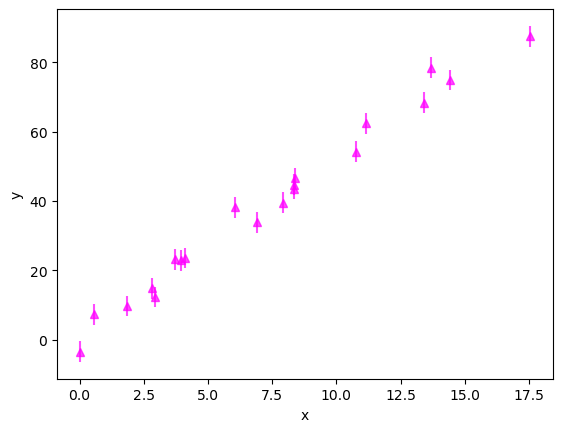

In [3]:
from pathlib import Path
import pandas as pd

root = Path.home()
file = root / 'github_reps'/'KL7002'/'datasets'/'least_squares.csv'

data = pd.read_csv(file)

_ = plt.errorbar(data['x'], data['y'], yerr=data['Uncertainty'], fmt='^', alpha=0.7, color='fuchsia')
_ = plt.xlabel('x')
_ = plt.ylabel('y')

#plt.savefig(save_path+'linear_data.png', dpi=300)

It can be seen that the data cannot lie exactly on any one single straight-line as the measurements are noisy. Each value of $y_i$ has some fluctuation about its true value, which is due to experimental uncertainty. This is natural for any data you will come across in real life situations. The data shown here has noise that is generated from a Normal distribution.

So, the question is: *'how can we find the values of $\hat{a}$ and $\hat{b}$ that provide the best estimate of the true values, and, as such, provide the best model for the given data?'* This is where the method of least-squares comes in.


## Objective function

The main idea behind the least-squares method is finding a quantitative way to judge which values of the model parameters provide the best description of the data. Finding the *point estimates* can be achieved through the calculation of a measure of distance between the model and the data, and then minimising the distance between our model (in this case a straight line) and our data points. This distance is captured by an **objective function** [1], also referred to as a *loss* or *cost* function.


 We want to minimise the weighted squared residuals for all data points, which means minimising the value of
\begin{equation}\label{eq:chi_sq}
\chi^2 = \sum_{i=1}^N \frac{\left(\hat{y}(x_i)-y_i\right)^2}{\sigma_i^2} 
       = \sum_{i=1}^N \frac{\left(\hat{a}+\hat{b}x_i-y_i\right)^2}{\sigma_i^2},
\tag{3.2}
\end{equation}
where $\sigma_i$ is the uncertainty on each of the data values, $y_i$. 

## Minimising the $\chi^2$

### Analytic solution
In the case of a straight line, it is possible to provide an analytic solution to this problem and a formula for $a$ and $b$ can be found using Equation 3.2.

\begin{equation}
a=\frac{1}{\Delta} \left( \sum \frac{x_i^2}{\sigma_i^2}\sum \frac{y_i}{\sigma_i^2}- \sum \frac{x_i}{\sigma_i^2}\sum \frac{x_i y_i}{\sigma_i^2}\right)
\tag{3.3}
\end{equation}

\begin{equation}
b=\frac{1}{\Delta} \left( \sum \frac{1}{\sigma_i^2}\sum \frac{x_iy_i}{\sigma_i^2}- \sum \frac{x_i}{\sigma_i^2}\sum \frac{y_i}{\sigma_i^2}\right)
\tag{3.4}
\end{equation}

\begin{equation}
{\Delta}=\sum \frac{1}{\sigma_i^2}\sum \frac{x_i^2}{\sigma_i^2}-\left(\sum \frac{x_i}{\sigma_i^2} \right)^2
\tag{3.5}
\end{equation}

Let us calculate this for our example data.

In [4]:
# Data
x_i = data['x']
y_i = data['y']
sigma_i = data['Uncertainty']

# Equation 3.5
delta = (1./sigma_i**2).sum() * (x_i**2/sigma_i**2).sum() \
         - (x_i/sigma_i**2).sum()**2

# Equation 3.3
a = 1/delta * ((x_i**2 / sigma_i**2).sum() * (y_i / sigma_i**2).sum()
               - (x_i / sigma_i**2).sum() * (x_i*y_i / sigma_i**2).sum()
               )

# Equation 3.4
b = 1 / delta * ((1 / sigma_i**2).sum() * (x_i*y_i / sigma_i**2).sum()
                 - (x_i / sigma_i**2).sum() * (y_i / sigma_i**2).sum()
                 )
print('Best fit value for a is {0:1.2f}'.format(a))
print('Best fit value for b is {0:1.2f} '.format(b))

Best fit value for a is 1.22
Best fit value for b is 5.16 


Hence these are the *point estimates*, $(\hat{a}, \hat{b})$, for the true values of $a$ and $b$. The true values for this data set are (3,5) - so these are reasonable.



Now visualise the $\chi^2$ surface close to the point estimates. In the following we calculate the values of $\chi^2$ for different values of $a$ and $b$ for our data. We then plot a slice through the surface at a fixed value of the intercept. 

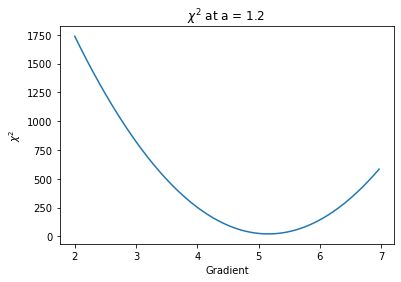

In [11]:
# Function to calculate the value of chi sqaured
def calc_chisq(yobs, x, sigma, param):
    ymod = param[0] + x*param[1]
    chi_sq = (ymod - yobs)**2/sigma**2
    return chi_sq.sum()


# Create a 2D grid of data points
range_grad = [2, 7]
range_inter = [-5, 5]
step = 0.1
grad_grid = np.arange(range_grad[0], range_grad[1], step/3)  # b values
inter_grid = np.arange(range_inter[0], range_inter[1], step)  # a values

chisq_grad = np.zeros((len(grad_grid), len(inter_grid)))

# Iterate over values of a and b - calculating chi^2
for j, jj in enumerate(grad_grid):
    for i, ii in enumerate(inter_grid):
        param = np.array([ii, jj])
        chisq_grad[j, i] = calc_chisq(
            data['y'], data['x'], data['Uncertainty'], param)

# Plot chi^2 for a single value of a
_ = plt.plot(grad_grid, chisq_grad[:, 62])
_ = plt.title('$\chi^2$ at a = {} '.format(1.2))
_ = plt.xlabel("Gradient")
_ = plt.ylabel("$\chi^2$")

<br>

We can see that, in one dimension, the $\chi^2$ follows a parabolic curve. The minimum value of the curve occurs for a gradient of $\approx5$ - which we should expect from our previous calculation of the best-fit parameters.

<br>
<br>
We can also build some intuition by showing the surface in two and three dimensions.

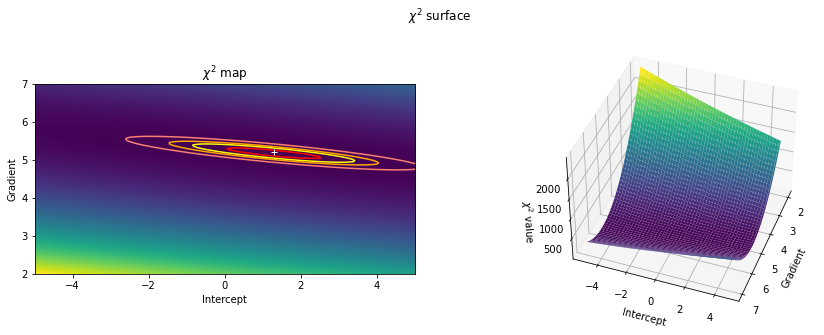

In [12]:
# Code for chi^2 plots
from mpl_toolkits import mplot3d

X_G, X_I = np.meshgrid(grad_grid, inter_grid) 

fig = plt.figure(figsize=(15,5))
fig.suptitle('$\chi^2$ surface')

ax = fig.add_subplot(1, 2, 1)
extent = [range_inter[0], range_inter[1], range_grad[0], range_grad[1]]
ax.imshow(chisq_grad-chisq_grad.min(), origin='lower', extent=extent )

# mark location of chi square minimum
ax.plot(1.3, 5.2, 'w+') 

# iso-surfaces of chi squares
colors = ['red', 'yellow', 'orange', 'salmon' ]
ax.contour(chisq_grad-chisq_grad.min(), [1, 3, 5, 10], extent = extent, colors=colors)
ax.set_ylabel("Gradient")
ax.set_xlabel("Intercept")
ax.set_title("$\chi^2$ map")

# Second subplot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

_ = ax2.plot_surface(X_G, X_I, chisq_grad.T,cmap='viridis', edgecolor='none')
_ = ax2.view_init(40,20)
_ = ax2.set_xlabel("Gradient")
_ = ax2.set_ylabel("Intercept")
_ = ax2.set_zlabel("$\chi^2$ value")

Both plots reveal that the $\chi^2$ surface is a paraboloid, which is more curved in the gradient direction than the intercept direction, with a minimum of the surface at $a=1.22$ and $b=5.16$. 


For a model with more parameters, we have a multi-dimensional surface for the $\chi^2$.

The 2D plot shows the location of the minimum value of $\chi^2$ (white cross) and contains contours to reveal the shape of the $\chi^2$ surface. The shape is a [bivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). The contours are iso-surfaces of $\chi^2$, showing the regions where the value of $\chi^2$ increases by 1, 3, 5, and 10 from the minimum value. The Gaussian in the gradient direction has a smaller scale than the Gaussian in the intercept direction, which is shown by the fact the contours are closer together in the gradient direction, suggesting a steeper slope. 

The greater curvature in the gradient plane suggests that we are better able to constrain the value of the gradient than the intercept. And this is reflected in the contours too - a larger range of values for the intercept give similar values for the $\chi^2$. This aspect leads us on to section 3.5, and how can we give uncertainties or errors on the model parameters we find. It turns out investigating the the $\chi^2$ surface can help us in more complicated situations.

### Numerical approach

There are a number of packages in Python that can perform a model-fit to data using least-squares. Some packages even have multiple implementations (e.g., Scipy). Here we will just look at the Scipy ```curve_fit``` implementation of least-squares.

First, it is required to define the model that we want to fit to the data. In this case we are focusing on a linear model, which is described by the following function.

In [10]:
# import curve fit from scipy
from scipy.optimize import curve_fit


# define function that describes model
def lin_func(x, a, b):
    return a + b * x

We can then pass the function that describes the model, and the data, to ```curve_fit```, which will then use a numerical method to find the minimum of the $\chi^2$. This is done by minimising the sum of the squared residuals defined by Equation 3.2 using [numerical optimisation](https://en.wikipedia.org/wiki/Mathematical_optimization).


The numerical method used here is called the [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg–Marquardt_algorithm) algorithm, which is a common numerical minimisation algorithm used for least-squares. We will not discuss the methods for minimisation in this course, but you should take the time to examine the different ones - even if it is only to be aware of the names and the restrictions associated with each method.

One of the restrictions with the Levenberg-Marquardt (LM) is it only finds a local minimum. The figure below shows a more complex $\chi^2$ surface. This surface has a local minimum and a global minimum. The global minimum is the one we are interested in finding. 


<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Extrema_example_original.svg">
<figcaption>Source: http://commons.wikimedia.org/wiki/File:Extrema_example.svg</figcaption>
</figure>


LM will start somewhere in the $\chi^2$ surface, and use a modified [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) method to find the minimum. However, depending upon where the LM starts on the surface, it may fall into the local minimum before it finds the global minimum. 

Hopefully we have an idea of what sort of parameter values we are expecting for our models, so we can provide an initial guess to ```curve_fit``` to guide the minimisation. An often used approach is to try various initial values to check whether you are finding a local or global minimum.

The following code now passes the function, data and initial guess to ```curve_fit``` and returns the best parameters that describes the model, given in *popt*. The other returned values, *pcov*, are the covariance matrix, which we will discuss in the next section.

In [11]:
# Suggest starting values for unknown parameters - initial guess
beta0 = [4, 6]

# pass model, data and initial guesses to curve fit
popt, pcov = curve_fit(lin_func, x_i, y_i, p0=beta0, sigma=sigma_i)

print('Best fit parameters for a={0:2.2f}, b={1:2.2f}'.format(
    popt[0], popt[1]))

Best fit parameters for a=1.22, b=5.16


As we can see, <font face = "menlo" > curve_fit</font> finds the same values we got from the analytic solution.

As a note, it is always computationally faster and more accurate to use analytic solutions (e.g. for the straight line these are Eqs. 3.3, 3.4, 3.5) to find the best parameters values, rather than a numerical method. So don't always rely on the numerical methods if you think you can find an analytic solution.

## Uncertainties on parameters

We have discussed a couple of ways to estimate the best parameters for our model, but how confident should we be in these *point estimates*? 

For simple models, such as the straight-line, there is an analytic way to calculate the uncertainties on each of the *point estimates*. You should know from the basic formula for error propagation that the error on a parameter, $z$, where $z=f(y_i)$ is given by:

$$
\sigma_z^2=\sum\left(\sigma_i^2\frac{\partial z}{\partial y_i}\right).
\nonumber
$$

As we have used our data points, $y_i$, in the calculation of our parameters, any error on those values, $\sigma_i$ should contribute to the error on the parameters.

It can be shown that, by taking the partial derivatives of Equations 3.3, 3.4, 3.5 with respect to $y_i$ and combining with general error formula above, that our uncertainties on the *point estimates* of the parameters for the straight line are given by [2]

$$
\sigma_a^2 = \frac{1}{\Delta}\sum\frac{x_i^2}{\sigma_i^2}, \,\,\, \sigma_b^2=\frac{1}{\Delta}\sum\frac{1}{\sigma_i^2}\,.
\nonumber
$$

And calculating these values for our data:

In [12]:
sigma_a = (1/delta * (x_i**2/sigma_i**2).sum())**0.5

sigma_b = (1/delta * (1/sigma_i**2).sum())**0.5

print('Analytic uncertainties sigma_a={0:2.2f}, sigma_b={1:2.2f}'.format(sigma_a, sigma_b))

Analytic uncertainties sigma_a=1.22, sigma_b=0.14


Hence, the values of the parameters that we would report in a paper/report are $a=1.2\pm1.2$ and $b=5.16\pm0.14$.
<br>

Under the assumption of a multi-variate Gaussian $\chi^2$ surface, then we can use the second derivatives of the $\chi^2$ surface to estimate the uncertainties on the parameters. The result is an $n\times n$ matrix ($n$ is the number of parameters) called the Hessian:

\begin{equation}
H_{j,k} = \frac{\partial^2 \chi^2_0}{\partial \beta_j\partial \beta_k}.
\tag{3.6}
\end{equation}

The inverse of the negative Hessian provides the so-called covariance matrix, 

\begin{equation}
\sigma_{j,k}^2 = \left(-H_{j,k}\right)^{-1}
\tag{3.7}
\end{equation}

which provides us with the standard error on our parameters. This covariance matrix is exactly what is returned from the LM method in ```curve_fit``` as *pcov*. Note, that just like the parameters, the covariance matrix from ```curve_fit``` is a numerical estimate. It is worth stressing that if you take these values from *pcov* to calculate the uncertainties, you implicitly assume your $\chi^2$ surface is a multi-variate Gaussian.



In order to obtain the standard errors (alternatively, formal 1$\sigma$ or marginal error)  from *pcov*, we take the diagonal elements of the matrix:

In [13]:
sigma = np.sqrt(np.diag(pcov))

print('Standard errors on a={0:2.2f} and b={1:2.2f}'
      .format(sigma[0], sigma[1]))

Standard errors on a=1.36 and b=0.15


We can increase the size of the interval to increase our certainty of the true value lying in the given interval, e.g.  $(a-1.645\sigma_a, a+1.645\sigma_a)$ is a $90\%$ confidence interval.

The values that multiply sigma are calculated from the standard normal percentiles. If we want a two-tailed probability interval for a value $\alpha$, then we have to find the $1-(1-\alpha)/2)$ percentile point function, e.g. for $\alpha=0.9$ then $1-(1-0.9)/2)=0.95$

In [14]:
from scipy import stats

print('Percentile point = {:2.3f}'.format(stats.norm.ppf(0.95)))

Percentile point = 1.645


The confidence intervals are referred to as Wald confidence intervals, and are valid if the $\chi^2$ surface is well approximated by a multi-variate Gaussian.

This naturally raises the question: What does our surface look like? Let's revisit an earlier figure.

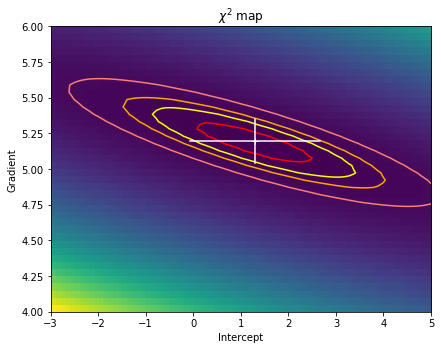

In [17]:
# zoom of chi-square
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 2, 1)
extent = [inter_grid[20], range_inter[1], grad_grid[40], grad_grid[80]]
ax.imshow(chisq_grad[40:80,20:]-chisq_grad.min(), origin='lower', extent=extent )

opt_par = [1.3, 5.2]
error_a = opt_par[0]+np.array((-sigma[0],sigma[0]))
error_b = opt_par[1]+np.array((-sigma[1],sigma[1]))

ax.plot(error_a, [opt_par[1], opt_par[1]], 'w')
ax.plot([opt_par[0], opt_par[0]], error_b, 'w')

# iso-surfaces of chi squares
colors = ['red', 'yellow', 'orange', 'salmon' ]
ax.contour(chisq_grad[40:80,20:]-chisq_grad.min(), [1, 3, 5, 10], extent = extent, colors=colors)
ax.set_ylabel("Gradient")
ax.set_xlabel("Intercept")
ax.set_title("$\chi^2$ map")

# mark location of chi square minimum
ax.plot(1.3, 5.2, 'w+')
ax.set_aspect(3)

You can see in this example that the iso-contours of the $\chi^2$ surface are ellipses. This suggests that the are surface is a reasonable approximation to a Gaussian (actually, in the case of a linear model it is a bivariate Gaussian). Hence, the error estimates returned from *pcov* are probably reasonable (again, in this case they should be exact, aside from sampling uncertainty). 


<br>

The diagonal elements in the covariance matrix are also important and provide information on how correlated our parameters estimates are, i.e. does the estimate of one parameter influence the other. 

If we examine our covariance matrix:

In [18]:
print(pcov)

[[ 1.8470345  -0.17531528]
 [-0.17531528  0.02386378]]


we can see that there is some correlation between parameters. This is most easily seen when looking at the $\chi^2$ surface with the contours on. You can see that the ellipses are at an angle to the parameter axis, as opposed to being aligned with the parameter axis. This indicates that the errors for the parameters are correlated.

We can convert the covariance matrix to a correlation matrix to see the degree of correlation:

In [19]:
#Calculate correlation matrix
D = np.sqrt(np.diag(pcov))

cor_mat = pcov/np.outer(D, D)

print(cor_mat)

[[ 1.         -0.83505025]
 [-0.83505025  1.        ]]


### Errors from the $\chi^2$ surface

There is an alternative method to estimate the uncertainties, which avoids the assumption that the $\chi^2$ surface is a multi-variate Gaussian, i.e. that the 2nd order Taylor expansion is not exact. This can occur if the number of data points you have is small or the $\chi^2$ surface for the model is not well behaved. This method is known as the Likelihood ratio confidence interval (and we'll discuss the more general case in the next lecture).

The following plot illustrates what we are trying to find. 

<table><tr>
<td>
    <figure>
    <img src='sigma_error_ellipse.png' height=500 >
    <figcaption>Source: Frank Porter - http://www.hep.caltech.edu/~fcp/statistics/sluo00/sluolec4.pdf </figcaption>
    </figure>
  </td>
  <td>
      <figure>
    <img src ="random_error_contour.png" height=500  >
      <figcaption>Source: Fred James - The Interpretation of errors http://lmu.web.psi.ch/docu/manuals/software_manuals/minuit2/mnerror.pdf</figcaption>
       </figure>
    </td>
</tr>
</table>

It shows the perfect example on the left, which in reality only occurs for a linear problem (or you have a lot of data and few model parameters). The model parameters are $(\theta_1, \theta_2)$. We can define an error ellipse using the values returned from the Hessian, and these values are a good approximation to the uncertainty. 

In more general cases, we have the situation on the right, where the iso-contours on the $\chi^2$ surface are not ellipses. In such situations, the values obtained from the Hessian are likely inaccurate, and the Likelihood ratio method helps us find the uncertainties. In this case, we want to find the smallest and largest values for our parameters (marked A and B, respectively, on the figure) that lie within a certain region .

For the least-squares situation, we can define regions of the $\chi^2$ surface where

$$
\chi^2 < \chi^2_0+\Delta\chi^2,
\nonumber
$$ 

which provides a joint confidence region for the parameters. Here $\chi^2_0$ is our minimum value of $\chi^2$, and $\Delta\chi^2$ is a factor that is calculated based on the number of parameters ($n$) and the confidence value we want. We then calculate a critical value from a $\chi^2_n$ distribution [2, Chapter 7.4]. This value will then define a contour within our $\chi^2$ surface, and the values of the parameters within that contoured region provide our estimates for the uncertainties.

We have $n=2$ parameters here, and suppose we want a $68\%$ confidence region, then $\Delta\chi^2$ can be calculated as:

In [16]:
print('Cut-off = {:2.3f}'.format(stats.chi2(2).ppf(0.68)))

Cut-off = 2.279


On the previous plot, the contours plotted show the regions $\chi^2 -\chi^2_0 < [1, 3, 5, 10]$. We have also over-plotted the standard error for each parameter obtained from the covariance matrix for comparison (white cross).

You can see that the endpoints of the standard error bars are close to the iso-contours of $\chi^2 -\chi^2_0 = 3$, which is what we expect (the grid I used for the plot is rather coarse which influences how things look). For multi-variate Gaussian $\chi^2$ surfaces the covariance matrix and Likelihood methods will provide similar estimates for the uncertainties on the parameters.


Using our critical value, we can then find the minimum and maximum values of the parameters that lie within the confidence region

In [21]:
cols, rows = (chisq_grad <= (chisq_grad.min()+2.279)).nonzero()
print('Intercept values - Lower={0:1.3f}, Upper={1:1.3f}'.format(inter_grid[rows.min()], inter_grid[rows.max()]))
print('Intercept uncertainties: -{0:1.3f}, +{1:1.3f}'.format(popt[0]-inter_grid[rows.min()],inter_grid[rows.max()]-popt[0] ))
print('Gradient values - Lower={0:1.3f}, Upper={1:1.3f}'.format(grad_grid[cols.min()], grad_grid[cols.max()]))
print('Gradient uncertainties: -{0:1.3f}, +{1:1.3f}'.format(popt[1]-grad_grid[cols.min()],grad_grid[cols.max()]-popt[1] ))

Intercept values - Lower=-0.500, Upper=3.000
Intercept uncertainties: -1.724, +1.776
Gradient values - Lower=4.950, Upper=5.350
Gradient uncertainties: -0.206, +0.194


There is some difference here between this calculation and the analytic and covariance matrix results. It will come down to the fact I have performed a quick and dirty calculation of where the contour lies. A much better method is required for a reasonable accuracy.



## Goodness of fit

Up until now we have been fitting models and assuming that the resulting fit is okay. How can judge whether we have a good fit? Or if that the model we are using for the data is a reasonable one?

For the second question, a visual inspection of the best fit result over-plotted on the data provides the first test of the goodness of fit. If the data in non-linear, e.g. quadratic, and you fit a straight line there will be a clear mismatch between the model and the data. However, it is not usually that obvious.

Consider the following figure. We have some data (blue points) and best fit models for a cubic and quartic. Which model best describes the data?

Number of data points N=100


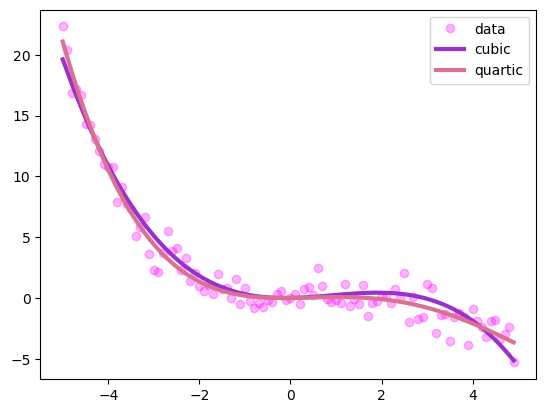

In [16]:
# figure code

# data
x = np.arange(-5, 5, 0.1)
y_mod = 1e-2*x**4 - 0.1*x**3+1e-1*x**2 + 0.05*x
y = y_mod + np.random.RandomState(10).randn(len(x))


def cubic_mod(x, a, b, c):
    return a*x**3+b*x**2+c*x


def quartic_mod(x, a, b, c, d):
    return a*x**3+b*x**2+c*x+d*x**4


beta0 = [0.1, 0.1, 0.1]
popt, pcov = curve_fit(cubic_mod, x, y, p0=beta0, sigma=np.ones(len(x)))

beta0 = [0.1, 0.1, 0.1, 0.01]
popt_q, pcov_q = curve_fit(quartic_mod, x, y, p0=beta0, sigma=np.ones(len(x)))

plt.plot(x, y, 'o', alpha=0.3, color='fuchsia', label='data')
plt.plot(x, cubic_mod(x, popt[0], popt[1],
                      popt[2]), label="cubic", linewidth=3, color='darkorchid')
plt.plot(x, quartic_mod(
    x, popt_q[0], popt_q[1], popt_q[2], popt_q[3]), label='quartic', linewidth=3,
        color='palevioletred')
plt.legend()

print("Number of data points N={}".format(len(x)))

plt.savefig(save_path+'/cubic_vs_quartic.png', dpi=300)

It turns out that how to assess the best model is an area that is still under debate. There are some often used methods, which are not without their criticisms. We will discuss one method here as it is still useful.

### Reduced $\chi^2$

For the least-squares method, a common technique to calculate a value called the reduced $\chi^2$, often written $\chi^2_\nu$, where

$$
\chi^2_\nu=\frac{\chi^2}{N-d},
\nonumber
$$
where the $\chi^2$ is the minimum value of $\chi^2$ calculated for your best fit parameters, $N$ is the number of data points you have and $d$ is the number of model parameters. The value $N-d$ is called the degrees of freedom.

The $\chi^2_\nu$ can give us an indication of how good the fit is. The ideal value of $\chi^2_\nu = 1$. This ideal value of 1 is based upon the $\chi^2$ probability distribution. If $\chi^2_\nu>1$ then you might be inclined to say the model is a bad fit (or under fitting the data). If $\chi^2_\nu<1$ you would probably say that the model is a bad one as it is over fitting that data, i.e. the model has too much flexibility and can start to fit the noise.

Using this information, you could also judge which model fits the data better, i.e. which model gives the value of $\chi^2_\nu$ closet to 1.

What are the values for our two models above?

In [23]:
# Calculate reduced chi squares


def reduced_chi_square(model, x, y, errs, *args):
    """ Function for calculating chi^2 """
    N = len(x)
    d = len(args)
    df = N-d
    return ((y - model(x, *args))**2/errs**2).sum()/df


chisq_red_cubic = reduced_chi_square(cubic_mod, x, y, np.ones(
    len(x)), popt[0], popt[1], popt[2])

chisq_red_quartic = reduced_chi_square(
    quartic_mod, x, y, np.ones(len(x)), popt_q[0], popt_q[1], popt_q[2], popt_q[3])


print('Reduced chi square cubic ={:2.3f}'.format(chisq_red_cubic))
print('Reduced chi square quartic ={:2.3f}'.format(chisq_red_quartic))

Reduced chi square cubic =1.258
Reduced chi square quartic =0.970


They are both reasonably close to one. You may even suggest that the quartic model is slightly better, i.e. slightly closer to one.

One restriction of the reduced $\chi^2$ is that it can really only be used for linear models (although often it is used for more complex models). Moreover, the value of $\chi^2$ depends on the data, which is noisy - so the value of $\chi^2_\nu$ is also an estimate (for a detailed discussion see [4]).

The reduced $\chi^2$ gives us a quick look at how well the model fits the data. There are some more preferable methods, for example that involve examining the distribution of the residuals or look at how well the model predicts removed data points (cross-validation). We will take a brief look at Cross-validation in Lecture 4.

## References

[1] Hogg, Bovy & Lang, Data analysis recipes: Fitting a model to data - [https://arxiv.org/abs/1008.4686](https://arxiv.org/abs/1008.4686)

[2] Bevington & Robinson, Data Reduction & Error Analysis for the Physical Sciences - Chapter 7 _Least-squares fit to a polynomial_ 

[3] Frequentism vs Bayesianism, Blog Post by VanderPlas [http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/)

[4] René Andrae, Tim Schulze-Hartung & Peter Melchior, Dos and don’ts of reduced chi-squared, arXiv:1012.3754v1



## Further Reading

* Bevington & Robinson, Data Reduction & Error Analysis for the Physical Sciences - Chapters 6, 7, & 8

* Wall & Jenkins, Practical Statistics for Astronomers - Chapter 6

* Feigelson & Babu, Modern Statistical Methods for Astronomy - Chapter 7

* Read the other parts of the VanderPlas blog on Frequentism vs Bayesianism [http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)

* Scipy lectures - [https://scipy-lectures.org/advanced/mathematical_optimization/index.html](https://scipy-lectures.org/advanced/mathematical_optimization/index.html)

## Alternative tools

* [https://lmfit.github.io/lmfit-py/intro.html](https://lmfit.github.io/lmfit-py/intro.html)

## Exercises

1. In this example you are going to repeat the process of fitting a straight line with the least-squares method. However, we will use an extended data set, containing more data to see what happens to our parameter estimates and their uncertainties.

a) Read in data in *'least_squares_exercise1.csv'* using pandas.

b) Plot the data and uncertainties

c) Using pandas, take a 100 random samples from the data set (pandas has an in-built function to do this) and fit the linear model to the data. Use <font face = "menlo" >curve_fit</font> instead of performing an analytic calculation. How do the best-fit parameter values and their uncertainties compare to the example in the notes?

d) Re-run the cell from the last example, specifically the random sampling from the data set. The data pairs $(x_i, y_i)$ should be different from the previous version. Compare the returned best-fit parameters values and uncertainties. Do they differ? Do you think they are consistent. Re-run a number of times to see what happens. Can you explain the differences?

e) Now use the full data set and repeat the fitting process. What happens to the uncertainties on the best-fit parameters? 

<br>

The following questions will take your through the process of generating your own data and then fitting a model via least squares. This process is useful as it enables you to understand the limitations of how you approach the estimation of parameters of interest, testing how well you can recover true values. This process is typically referred to as Monte Carlo simulation.

2. We believe that our data is generated from a quadratic process and the data will have errors that can be considered to be normally distributed $\mathcal{N}(0,1)$. Let us generate a possible instance of the measurement process. Our data will be measured at values of $x$ which can run from -10 to 10, and will be measured at intervals of every 0.5 units. Define a function that generates the $y$-values that obey the stated conditions, where the quadratic is given by $ax^2+bx+c$ and the true values are $a=0.1$, $b=5=0.01$, $c=-2$. Plot the data and error bars.

3. Now, fit a quadratic function to our fake data using <font face = "menlo" >curve_fit</font>. Over plot the best-fit model on the data. 

4. In this exercise we will fit a Gaussian to some noisy data.

a) Read in data in *'least_squares_exercise4.csv'* using pandas.

b) Plot the data and uncertainties.

c) Create a function that describes a Gaussian and calculate the best fit parameters and uncertainties.

d) Examine the $\chi^2$ hyper-surface. This will have to be done in 2D. Calculate and plot the surface for amplitude and center of the Gaussian, with the width fixed at the best estimate value. Do the same for amplitude and width, fixing the center value. Do the plots compare to your expectations given the covariance matrix?

5. In the following exercise we will work with data from the [Hinode satellite](http://www.isas.jaxa.jp/home/solar/), taken with the Extreme-ultraviolet Imaging Spectrometer (EIS) instrument. EIS observes EUV wavelengths, hence is focused on examining the Sun's corona.

For this exercise you will use the same data as in Lab 1. You will need to download again with Sunpy.

Hinode/EIS is designed to observe a number of specific wavelengths. The one we will work with here is centered around 195Å and corresponds to emission from Fe XII, which has a peak formation temperature of around 1.5 MK.

a) Plot the spectrum at the spatial location (350, 50) as a function of wavelength.

b) Fit the spectrum at this location with 3 models. i) A simple Gaussian; ii) A Gaussian plus a constants; iii) A Gaussian plus a straight line. Overplot these on the original data.

c) Calculate the reduced $\chi^2$ to examine which model might provide the best description of the data.